In [2]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index().drop('level_0', axis=1)
    merged = pd.merge(
        df, source_data[group_columns],
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In 1980, a typical Bengali woman could have 5 or more children in her lifetime. By the year 200, a typical Bengali woman had only 2 or 3. You’re going to look at a historical set of data, when contraception was widely available but many families chose not to use it. These data reside in `bangladesh` and come from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables, but you can focus on three of them for this practice problem:

* `district`: ID number of administrative district each woman resided in
* `use.contraception`: An indicator (0/1) of whether the woman was using contraception
* `urban`: An indicator (0/1) of whether the woman lived in a city, as opposed to living in a rural area


In [3]:
data = pd.read_csv('../data/bangladesh.csv', sep=';')

districts = (data.district.drop_duplicates()
             .reset_index(drop=True).reset_index()
             .set_index('district')['index'].rename('district_i').to_frame())
num_districts = districts.shape[0]

data = pd.merge(data, districts, left_on='district', right_index=True)

data = data.assign(
    age_s = data['age.centered'] / data['age.centered'].std(),
    children = data['living.children'] / 4.,
    using = data['use.contraception']
)

data = data[['district_i', 'age_s', 'children', 'urban', 'using']]

data.sample(5)

,district_i,age_s,children,urban,using
1101,32,0.159765,1.00,1,1
1275,39,-0.838755,0.25,1,0
914,27,1.047348,1.00,0,1
1446,44,1.158295,1.00,0,1
416,12,0.714504,1.00,1,1


In [7]:
with pm.Model() as m_avg:
    a = pm.Normal('a', mu=0, sd=2)
    p = pm.Deterministic('p', pm.math.invlogit(a))

    use_obs = pm.Binomial('use_obs', n=1, p=p,
                          observed=data.using.values)

    m_avg.name = 'average'
    m_avg.trace = pm.sample(5000, tune=1000, chains=2)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3305.40draws/s]


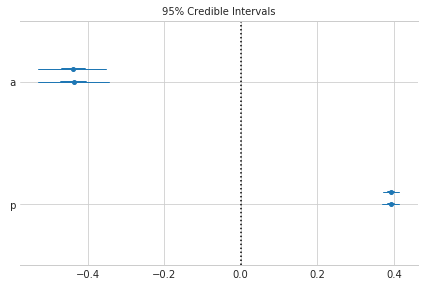

In [8]:
pm.forestplot(m_avg.trace, rhat=False)
None

In [10]:
with pm.Model() as m_var_districts:
    a = pm.Normal('a', mu=0, sd=1)
    district_sd = pm.Exponential('district_sd', lam=1)

    district_a = pm.Normal('district_a', mu=0, sd=district_sd,
                           shape=num_districts)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            -0.42
            + a
            + district_a[data.district_i.values]
        )
    )

    use_obs = pm.Binomial('use_obs', n=1, p=p,
                          observed=data.using.values)

    m_var_districts.name = 'variate districts'
    m_var_districts.trace = pm.sample(5000, tune=1000, chains=2)


INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [district_a, district_sd, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:22<00:00, 539.71draws/s]


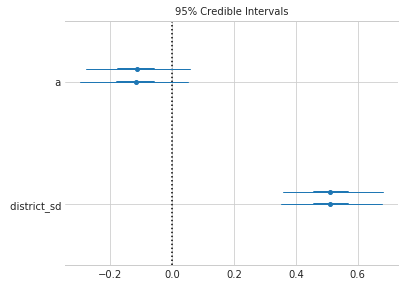

In [11]:
pm.forestplot(m_var_districts.trace, varnames=['a', 'district_sd'], rhat=False)
None

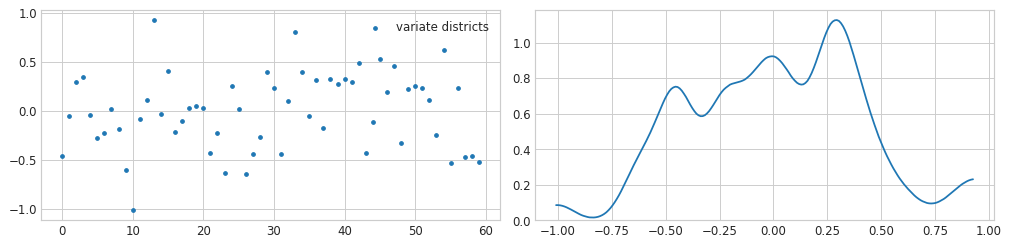

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), dpi=85)
tmp = pd.Series(m_var_districts.trace['district_a'].mean(axis=0))
ax1.scatter(tmp.index, tmp,
            label=m_var_districts.name, marker='.')
ax1.legend()

pm.kdeplot(tmp, ax=ax2)

fig.tight_layout()
None

In [13]:
with pm.Model() as m_var_districts_urban:
    b_urban = pm.Normal('b_urban', mu=0, sd=1, shape=2)
    district_sd = pm.Exponential('district_sd', lam=1)

    district_a = pm.Normal('district_a', mu=0, sd=district_sd,
                           shape=num_districts)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            -0.4
            + b_urban[data.urban.values]
            + district_a[data.district_i.values]
        )
    )

    use_obs = pm.Binomial('use_obs', n=1, p=p,
                          observed=data.using.values)

    m_var_districts_urban.name = 'urban, variate districts'
    m_var_districts_urban.trace = pm.sample(5000, tune=2000, chains=2)


INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [district_a, district_sd, b_urban]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:27<00:00, 502.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


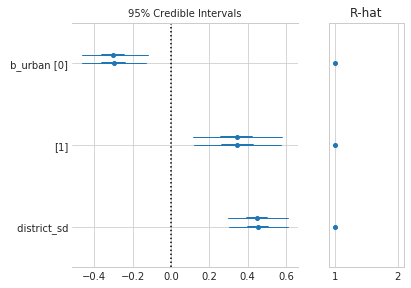

In [14]:
pm.forestplot(m_var_districts_urban.trace,
              varnames=['b_urban', 'district_sd'], 
              rhat=True)
None

In [21]:
with pm.Model() as m_var_districts_urban_2:
    a = pm.Normal('a', mu=0, sd=1)
    district_sd = pm.Exponential('district_sd', lam=1, shape=2)

    district_a = pm.Normal('district_a', mu=[0, 0], sd=district_sd,
                           shape=(num_districts, 2))

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            -0.42
            + a
            + district_a[tuple([data.district_i.values,
                                data.urban.values])]
        )
    )

    use_obs = pm.Binomial('use_obs', n=1, p=p,
                          observed=data.using.values)

    m_var_districts_urban_2.name = 'variate districts x2'
    m_var_districts_urban_2.trace = pm.sample(3000, tune=1500, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [district_a, district_sd, a]
Sampling 2 chains: 100%|██████████| 9000/9000 [01:02<00:00, 143.84draws/s]
The number of effective samples is smaller than 25% for some parameters.


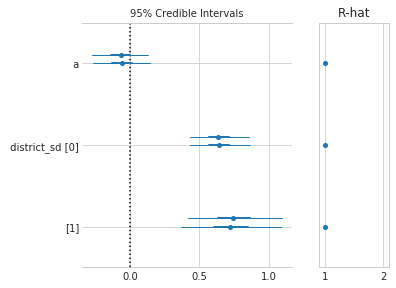

In [25]:
pm.forestplot(m_var_districts_urban_2.trace,
              varnames=['a', 'district_sd'], 
              rhat=True)
None

In [24]:
pm.compare({
    m_avg: m_avg.trace,
    m_var_districts: m_var_districts.trace,
    m_var_districts_urban: m_var_districts_urban.trace,
    m_var_districts_urban_2: m_var_districts_urban_2.trace,
})

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
/root/etc/venv/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/root/etc/venv/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/root/etc/venv/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error 

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
variate districts x2,2473.57,58.49,0,0.73,27.81,0,0
"urban, variate districts",2490.53,33.13,16.96,0.27,26.61,12.24,0
variate districts,2514.44,35.57,40.87,0,25.02,12.42,0
average,2592.89,0.99,119.32,0,18.78,21.53,0


*Note*: Minimal gain in WAIC, while pWAIC almost doubles - we continue building with `urban, variate districts`.

In [26]:
with pm.Model() as m_age:
    b_urban = pm.Normal('b_urban', mu=0, sd=1, shape=2)
    district_sd = pm.Exponential('district_sd', lam=1)
    b_age = pm.Normal('b_age', mu=0, sd=1)

    district_a = pm.Normal('district_a', mu=0, sd=district_sd,
                           shape=num_districts)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            -0.42
            + b_urban[data.urban.values]
            + district_a[data.district_i.values]
            + b_age * data.age_s.values
        )
    )

    use_obs = pm.Binomial('use_obs', n=1, p=p,
                          observed=data.using.values)

    m_age.name = 'urban & age, variate districts'
    m_age.trace = pm.sample(3000, tune=1500, chains=2)


INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [district_a, b_age, district_sd, b_urban]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:23<00:00, 390.51draws/s]


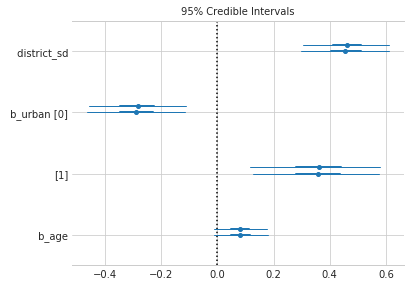

In [27]:
pm.forestplot(m_age.trace,
              varnames=['district_sd', 'b_urban', 'b_age'],
              rhat=False)
None

In [31]:
with pm.Model() as m_all:
    district_sd = pm.Exponential('district_sd', lam=1)
    b_urban = pm.Normal('b_urban', mu=0, sd=1, shape=2)
    b_age = pm.Normal('b_age', mu=0, sd=1)
    b_children = pm.Normal('b_children', mu=0, sd=1)

    district_a = pm.Normal('district_a', mu=0, sd=district_sd,
                           shape=num_districts)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            - 0.42
            + b_urban[data.urban.values]
            + district_a[data.district_i.values]
            + b_age * data.age_s.values
            + b_children * data.children.values
        )
    )

    use_obs = pm.Binomial('use_obs', n=1, p=p,
                          observed=data.using.values)

    m_all.name = 'all, variate districts'
    m_all.trace = pm.sample(5000, tune=2000, chains=2)


INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [district_a, b_children, b_age, b_urban, district_sd]
Sampling 2 chains: 100%|██████████| 14000/14000 [01:05<00:00, 213.98draws/s]


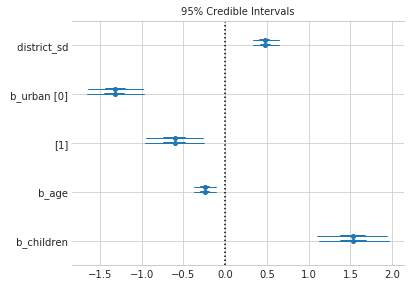

In [33]:
pm.forestplot(m_all.trace,
              varnames=['district_sd', 'b_urban', 'b_age', 'b_children'],
              rhat=False)
None

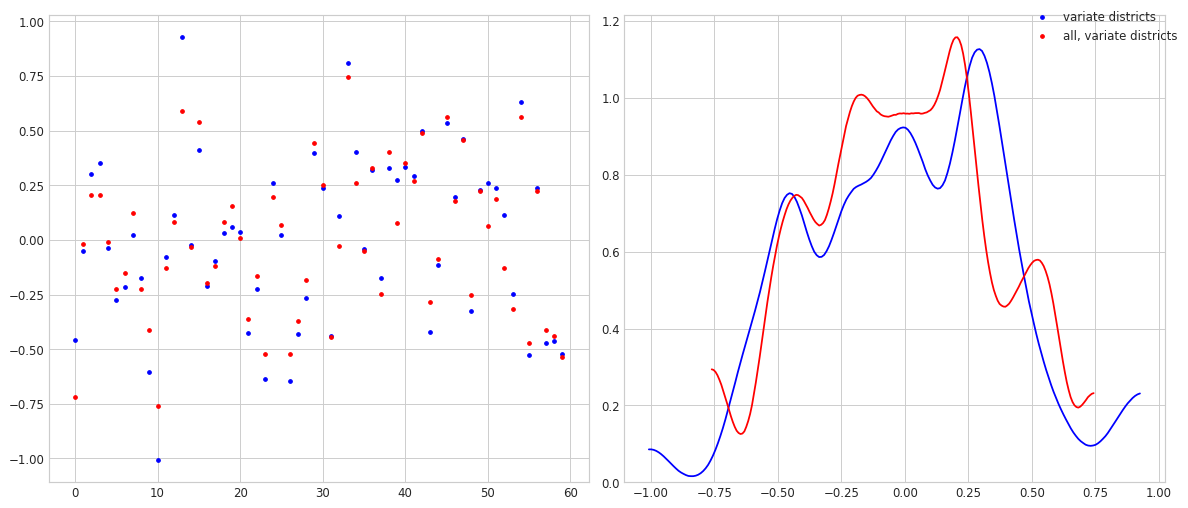

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=85)
tmp1 = pd.Series(m_var_districts.trace['district_a'].mean(axis=0))
tmp2 = pd.Series(m_all.trace['district_a'].mean(axis=0))
ax1.scatter(tmp1.index, tmp1,
            label=m_var_districts.name, marker='.', c='b')
ax1.scatter(tmp2.index, tmp2,
            label=m_all.name, marker='.', c='r')

pm.kdeplot(tmp1, ax=ax2, label='', c='b')
pm.kdeplot(tmp2, ax=ax2, label='', c='r')

fig.tight_layout()
fig.legend()
None

In [43]:
pm.compare({
    m_var_districts_urban: m_var_districts_urban.trace,
    m_age: m_age.trace,
    m_all: m_all.trace,
})

/root/etc/venv/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
/root/etc/venv/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/root/etc/venv/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error 

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
"all, variate districts",2433.76,35.83,0,1,29.11,0,0
"urban & age, variate districts",2489.77,34.62,56.01,0,26.85,13.4,0
"urban, variate districts",2490.53,33.13,56.77,0,26.61,13.81,0
